In [ ]:
import pandas as pd 
import numpy as np 

In [ ]:
import torch
import transformers
from transformers import BertForSequenceClassification, XLMRobertaForSequenceClassification, AdamW, BertConfig, BertTokenizer, XLMRobertaTokenizer
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import re
from bs4 import BeautifulSoup

In [ ]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [ ]:
'''
Construct object in BERT sentiment classifier class
'''
sentiment_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False # Whether the model returns all hidden states.
)

sentiment_model.cuda() # Puts model on GPU

'''
Load pretrained sentiment model parameters
'''
sentiment_model.load_state_dict(torch.load("/content/drive/My Drive/English_sentiment_model.pt", map_location=torch.device('cpu')), strict=False)

sentiment_model.eval() # Put model in inference (as opposed to training) mode

'''
Load tokenizer for sentiment model
'''
sentiment_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# gets the text into the format we want
def clean_tweet(tweet):
  tweet = BeautifulSoup(tweet, "lxml").get_text() # turns xml-formatted text into regular text
  tweet = re.sub(r"@[A-Za-z0-9]+", " ", tweet) # gets rid of all user references in tweets (i.e. "@username")
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", " ", tweet) # gets rid of URLs
  tweet = re.sub(r"[^A-Za-z.!?áéíóúüñ¿ÁÉÍÓÚÜÑ']", " ", tweet) # gets rid of any non-standard characters in the tweets
  tweet = re.sub(r" +", " ", tweet) # replaces all excess whitespace with a single space

  return tweet # gives us our cleaned tweet

def predict_sentiment(tweet):

    '''
    Predict the sentiment of an input text
    '''
    
    tweet = clean_tweet(tweet)
    tweet_input_id = []
    tweet_attention_mask = []

    tweet_dict = sentiment_tokenizer.encode_plus(
                            tweet,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 64,           # Pad & truncate all sentences.
                            truncation=True,           # Explicitly enable truncation
                            padding = 'max_length',
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

    # Add the encoded sentence to the list.    
    tweet_input_id.append(tweet_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    tweet_attention_mask.append(tweet_dict['attention_mask'])

    # Convert the lists into tensors.
    tweet_input_id = torch.cat(tweet_input_id, dim=0)
    tweet_attention_mask = torch.cat(tweet_attention_mask, dim=0)

    tweet_data = TensorDataset(tweet_input_id, tweet_attention_mask)
    
    tweet_dataloader = DataLoader(tweet_data)
    
    for data in tweet_dataloader:
        tweet_input_id = data[0].to(device=torch.device('cuda'))
        tweet_attention_mask = data[1].to(device=torch.device('cuda'))
    
    tweet_logits = sentiment_model(tweet_input_id, token_type_ids=None, attention_mask=tweet_attention_mask)
    
    tweet_logits = tweet_logits[0].detach().cpu().numpy()

    tweet_logits = torch.Tensor(tweet_logits)

    softmax = torch.nn.Softmax(dim=1)
    prob_dist = softmax(tweet_logits)

    sentiment_pred = prob_dist.tolist()

    sentiment_pred = sentiment_pred[0][1]

    return sentiment_pred

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [ ]:
# #alternate sentiment model 
# from transformers import AutoModelForSequenceClassification
# from transformers import TFAutoModelForSequenceClassification
# from transformers import AutoTokenizer
# import numpy as np
# from scipy.special import softmax
# import csv
# import urllib.request

# # Preprocess text (username and link placeholders)
# def preprocess(text):
#     new_text = []
#     for t in text.split(" "):
#         t = '@user' if t.startswith('@') and len(t) > 1 else t
#         t = 'http' if t.startswith('http') else t
#         new_text.append(t)
#     return " ".join(new_text)

# # Tasks:
# # emoji, emotion, hate, irony, offensive, sentiment
# # stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

# task='sentiment'
# MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

# tokenizer = AutoTokenizer.from_pretrained(MODEL)

# # download label mapping
# labels=[]
# mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
# with urllib.request.urlopen(mapping_link) as f:
#     html = f.read().decode('utf-8').split("\n")
#     csvreader = csv.reader(html, delimiter='\t')
# labels = [row[1] for row in csvreader if len(row) > 1]

# # PT
# model = AutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained(MODEL)
# tokenizer.save_pretrained(MODEL)
# device = torch.device("cuda")
# model = model.to(device)
# model.eval()


In [ ]:
# def predict_sentiment(text):  
#   text = preprocess(text)
#   encoded_input = tokenizer(text, return_tensors='pt').to(device)
#   output = model(**encoded_input)
#   scores = output[0][0].detach().cpu().numpy()
#   scores = softmax(scores)
#   score = 0
#   for i in range(len(scores)):
#     score += (i-1)*scores[i]
#   return score

In [ ]:
#Another version of semantic distance here 
from transformers import pipeline 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=8d37a77239ed50d672ec9c829884d2de121525b547e98db966cbf3565b21133e
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [ ]:
#sentence level embeddings 
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
decfat = "https://raw.githubusercontent.com/gokulsrin/DecisionFatigue/master/data/full/generations_table_export_2022-09-30_230801.csv?token=GHSAT0AAAAAABY2AT4PVZSOGWYCHT5C5SD4Y3IN24A"
generations = pd.read_csv(decfat)

In [ ]:
#the top answers (in order
answers = {
    "Heinz": ["Ask family/friends for money", "Fundraise money", "Seek government or charity assistance", "Take out a loan", "Don't get treatment", "Get another job"], 
    "Josh": ["Call a taxi", "Call a tow truck or roadside assistance service (e.g., AAA)", "Hitchhike a ride", "Call family/friends for help", "Miss/cancel the trip", "Walk/run to the airport"],
    "Brian": ["Put his own money in", "Tell his manager the truth", "Lie about missing money/fudge numbers", "Ask his coworkers about missing money", "Pool money with coworkers", "Ignore the missing money/do nothing"],
    "Liz": ["Renew her membership", "Use the front desk\’s phone", "Borrow someone else\’s phone", "Leave the gym", "Sneak in to the gym", "Wait for her friend"], 
    "Mary": ["Tell the teacher the truth", "Call her mom", "Redo assignment before class", "Copy someone else\’s homework", "Turn nothing in/do nothing", "Skip class"],
    "Brad": ["Start a fire (not for signal)", "Call for help", "Keep hiking", "Stay put/make shelter", "Kill/eat his friends", "Search/hunt for food"], 
    "Darya": ["Go without him", "Skip the concert", "Go home to find ticket", "Give him her ticket", "Try to buy another ticket", "Help him sneak in"], 
    "Eunice": ["Go talk to the family", "Talk to the teen", "Yell at/confront the teen", "Ignore the situation", "Call 911", "Watch closely"], 
    "Eamon": ["Call 911", "Pull over", "Pass the car", "Take a detour", "Honk at the driver", "Slow down/avoid driver"],
}

In [ ]:
#analyze sentiment of the top answers 
sentiment = [[] for i in range(6)]
for vign in answers:
  for i in range(len(answers[vign])):
    sentiment[i].append(predict_sentiment(answers[vign][i]))

In [ ]:
nums = [i for i in range(6)]
for i in range(len(sentiment)):
  sentiment[i] = sum(sentiment[i])/len(sentiment[i])
x = nums
y = sentiment 

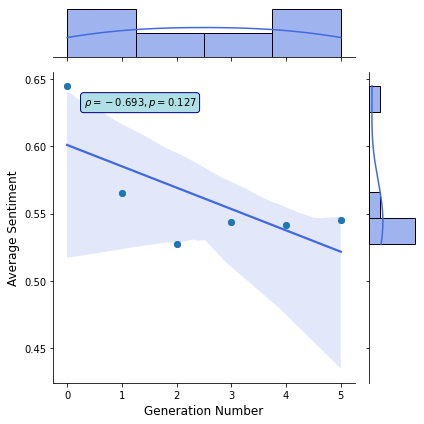

In [ ]:
import seaborn as sns 
import scipy.stats as stats
import matplotlib.pyplot as plt

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Sentiment', size=12)
plt.tight_layout()
plt.show()

In [ ]:
generations

,id,vignette_name,generation_number,generation_time,response,reflection_score
0,60f0ff19f34b192357d7d5d8,Brian,0,38837,review the transactions for the day and try to...,31
1,60f0ff19f34b192357d7d5d8,Brian,1,21918,look for the missing money maybe it fell under...,15
2,60f0ff19f34b192357d7d5d8,Brian,2,119718,assess if any coworkers would be likely to tak...,5
3,60f0ff19f34b192357d7d5d8,Brian,3,61550,find a trusted coworker and investigate the pr...,20
4,60f0ff19f34b192357d7d5d8,Brian,4,27189,find out if the money was missing at the start...,10
...,...,...,...,...,...,...
5665,616d9ef881036dfbfd63d2f4,Darya,1,34114,ask someone for a spare ticket,66
5666,616d9ef881036dfbfd63d2f4,Darya,2,32997,listen to the concert from outside,59
5667,616d9ef881036dfbfd63d2f4,Darya,3,29636,buy a new ticket,62
5668,616d9ef881036dfbfd63d2f4,Darya,4,35453,jump the queue,68


In [ ]:
persons = {}
for id, group in generations.groupby("id"):
  persons[id] = len(group["response"])

In [ ]:
persons
len(persons)
from tqdm import tqdm 

In [ ]:
sentiment = [[] for i in range(6)]

for pnum, group in generations.groupby("generation_number"):
  for response in tqdm(group["response"]):
    if not pd.isna(response):
        sentiment[pnum].append(predict_sentiment(response))

100%|██████████| 945/945 [00:11<00:00, 79.54it/s]


In [ ]:
sentiment

[[0.6432363390922546,
  0.21707893908023834,
  0.45530346035957336,
  0.7325946092605591,
  0.6743224859237671,
  0.8598496317863464,
  0.6089139580726624,
  0.8652697205543518,
  0.9346327185630798,
  0.6817663311958313,
  0.1735774725675583,
  0.698919415473938,
  0.8779642581939697,
  0.3138027787208557,
  0.5223995447158813,
  0.24461981654167175,
  0.8094450831413269,
  0.6108042597770691,
  0.9512256383895874,
  0.9235100150108337,
  0.12747129797935486,
  0.8174647092819214,
  0.9219433069229126,
  0.2837892770767212,
  0.37201428413391113,
  0.6676274538040161,
  0.8059155941009521,
  0.8036335110664368,
  0.8112881779670715,
  0.2494894415140152,
  0.680882453918457,
  0.25192251801490784,
  0.1710456758737564,
  0.565701961517334,
  0.565701961517334,
  0.5436026453971863,
  0.8408863544464111,
  0.8623872399330139,
  0.9143619537353516,
  0.8223748207092285,
  0.6277634501457214,
  0.6089139580726624,
  0.08931183815002441,
  0.83571857213974,
  0.9328754544258118,
  0.03492

In [ ]:
#create df for violin plot 
newdf = pd.DataFrame()
nums = []
sents = []
for i in range(len(sentiment)):
  for p in sentiment[i]:
    nums.append(i)
    sents.append(p)
newdf["generation_number"] = nums
newdf["sentiment"] = sents 

In [ ]:
newdf

,generation_number,sentiment
0,0,0.643236
1,0,0.217079
2,0,0.455303
3,0,0.732595
4,0,0.674322
...,...,...
5665,5,0.048459
5666,5,0.673496
5667,5,0.397737
5668,5,0.955297


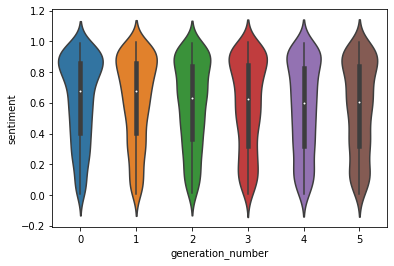

In [ ]:
sns.violinplot(data=newdf, x="generation_number", y="sentiment")

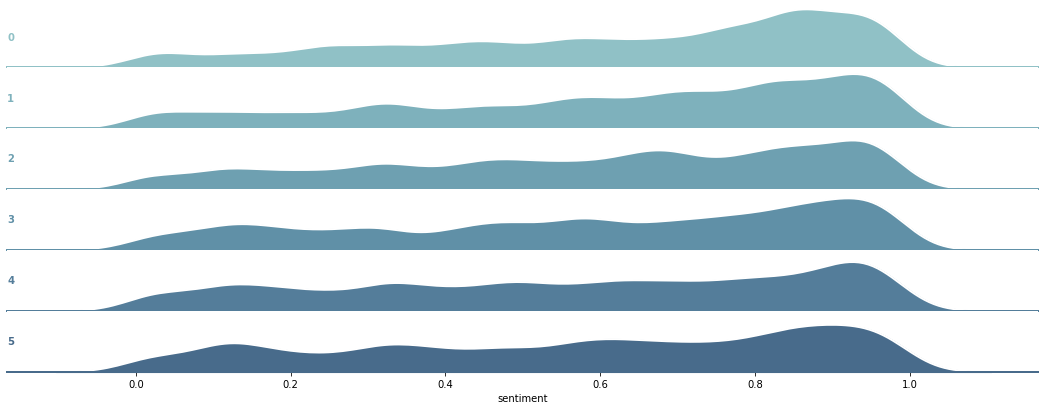

In [ ]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(newdf, row="generation_number", hue="generation_number", aspect=15, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "sentiment",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "sentiment", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .5, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "sentiment")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=0)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
#flip axis 

In [ ]:
nums = [i for i in range(6)]
for i in range(len(sentiment)):
  sentiment[i] = sum(sentiment[i])/len(sentiment[i])
x = nums
y = sentiment 

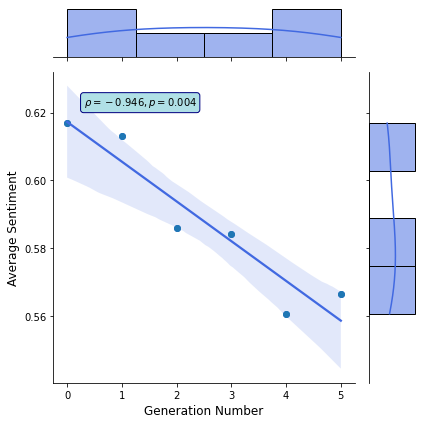

In [ ]:
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Sentiment', size=12)
plt.tight_layout()
plt.show()

In [ ]:
#eli og data
generations = pd.read_csv("https://raw.githubusercontent.com/gokulsrin/PossibilityGeneration/main/EliData/EliDataModified.csv")

In [ ]:
generations

,Unnamed: 0,vignette_name,generation_number,response,reflection_score,id
0,0,1,1,Ask family/friends for money.,0.850000,1
1,1,1,2,Try and find it cheaper elsewhere.,0.803333,1
2,2,1,3,Take out a loan.,0.473333,1
3,3,1,4,Pay it anyways.,0.776667,1
4,4,1,5,Try and haggle with insurance or seller.,0.583333,1
...,...,...,...,...,...,...
9315,9315,18,1,keep going and ignore the competitor,0.413333,311
9316,9316,18,2,stop and try to help them,0.890000,311
9317,9317,18,3,find a way to send a message to people that so...,0.830000,311
9318,9318,18,4,stop and also try and get other people to stop,0.576667,311


In [ ]:
sentiment= [[] for i in range(5)]
vigns = set([i for i in range(1,10)])

for pnum, group in generations.groupby("generation_number"):
  for response, vign in tqdm(zip(list(group["response"]), list(group["vignette_name"]))):
    if not pd.isna(response) and vign in vigns:
        sentiment[pnum-1].append(predict_sentiment(response))



1865it [00:11, 156.75it/s]
1861it [00:12, 154.20it/s]
1865it [00:11, 156.73it/s]
1864it [00:11, 156.58it/s]
1865it [00:12, 154.41it/s]


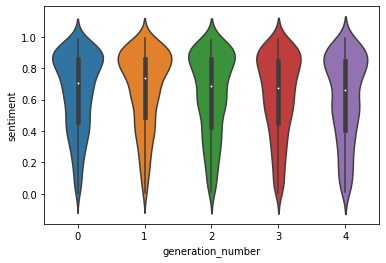

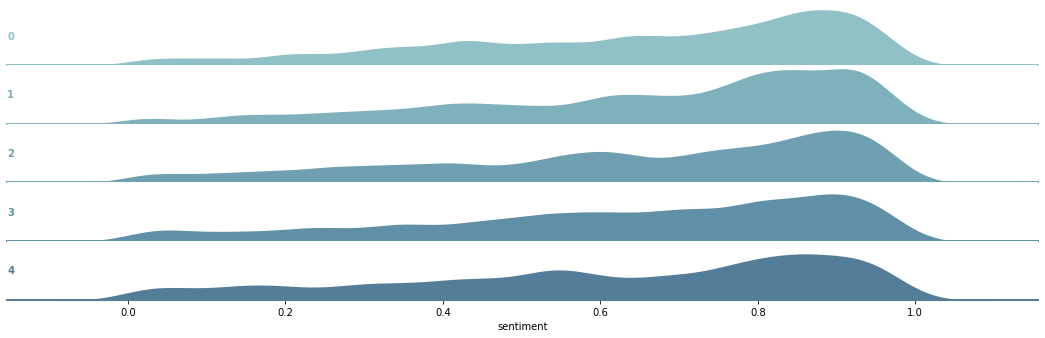

In [ ]:
#create df for violin plot 
newdf = pd.DataFrame()
nums = []
sents = []
for i in range(len(sentiment)):
  for p in sentiment[i]:
    nums.append(i)
    sents.append(p)
newdf["generation_number"] = nums
newdf["sentiment"] = sents 


sns.violinplot(data=newdf, x="generation_number", y="sentiment")

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(newdf, row="generation_number", hue="generation_number", aspect=15, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "sentiment",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "sentiment", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .5, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "sentiment")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=0)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)


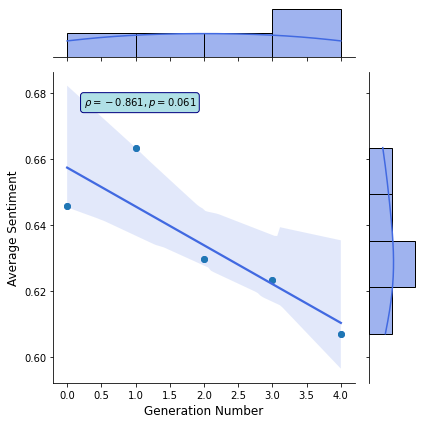

In [ ]:
nums = [i for i in range(5)]
for i in range(len(sentiment)):
  sentiment[i] = sum(sentiment[i])/len(sentiment[i])
x = nums
y = sentiment 

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Sentiment', size=12)
plt.tight_layout()
plt.show()

In [ ]:
generations["vignette_name"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18])

In [ ]:
import seaborn as sns 
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm 

In [ ]:
#combine these datasets 
# this is the fatigue data where we had them generate 6 possibilities and the vigns were names (dataset = 0)
generations1 = pd.read_csv(decfat)
# informations1 = pd.read_csv("https://raw.githubusercontent.com/gokulsrin/DecisionFatigue/master/data/full/information_table_export_2022-09-30_230807.csv?token=GHSAT0AAAAAABY2AT4OAYR64GTFUZIMQDIGYZYKXBQ")
# this is eli data where they generated 5 possibilites and the vigns were numbers (dataset = 1)
generations2 = pd.read_csv("https://raw.githubusercontent.com/gokulsrin/PossibilityGeneration/main/EliData/EliDataModified.csv")

In [ ]:
generations1

,id,vignette_name,generation_number,generation_time,response,reflection_score
0,60f0ff19f34b192357d7d5d8,Brian,0,38837,review the transactions for the day and try to...,31
1,60f0ff19f34b192357d7d5d8,Brian,1,21918,look for the missing money maybe it fell under...,15
2,60f0ff19f34b192357d7d5d8,Brian,2,119718,assess if any coworkers would be likely to tak...,5
3,60f0ff19f34b192357d7d5d8,Brian,3,61550,find a trusted coworker and investigate the pr...,20
4,60f0ff19f34b192357d7d5d8,Brian,4,27189,find out if the money was missing at the start...,10
...,...,...,...,...,...,...
5665,616d9ef881036dfbfd63d2f4,Darya,1,34114,ask someone for a spare ticket,66
5666,616d9ef881036dfbfd63d2f4,Darya,2,32997,listen to the concert from outside,59
5667,616d9ef881036dfbfd63d2f4,Darya,3,29636,buy a new ticket,62
5668,616d9ef881036dfbfd63d2f4,Darya,4,35453,jump the queue,68


In [ ]:
sentiment1= [[] for i in range(5)]
vigns = set([i for i in range(1,10)])

#little preprocessing 
# ids = set(informations1["id"].unqiue())

for pnum, group in generations1.groupby("generation_number"):
  for response, vig, id in tqdm(zip(list(group["response"]), list(group["vignette_name"]), list(group["id"]))):
    # only if id is in the ids set, which means it's in the info table, and the pnum is < 5 meaning (0-4)
    if not pd.isna(response) and pnum < 5:
        sentiment1[pnum].append(predict_sentiment(response))



945it [00:21, 43.78it/s]
945it [00:13, 70.69it/s]
945it [00:11, 80.00it/s]
945it [00:11, 80.41it/s]
945it [00:11, 79.18it/s]
945it [00:00, 498067.01it/s]


In [ ]:
newdf = pd.DataFrame()
nums = []
sents = []
for i in range(len(sentiment1)):
  for p in sentiment1[i]:
    nums.append(i)
    sents.append(p)

newdf["sentiment"] = sents
newdf["generation_number"] = nums
newdf["dataset"] = [0 for i in range(len(sents))]

In [ ]:
newdf

,sentiment,generation_number,dataset
0,0.643236,0,0
1,0.217079,0,0
2,0.455303,0,0
3,0.732595,0,0
4,0.674322,0,0
...,...,...,...
4720,0.742449,4,0
4721,0.909843,4,0
4722,0.873126,4,0
4723,0.420073,4,0


In [ ]:
generations2

,Unnamed: 0,vignette_name,generation_number,response,reflection_score,id
0,0,1,1,Ask family/friends for money.,0.850000,1
1,1,1,2,Try and find it cheaper elsewhere.,0.803333,1
2,2,1,3,Take out a loan.,0.473333,1
3,3,1,4,Pay it anyways.,0.776667,1
4,4,1,5,Try and haggle with insurance or seller.,0.583333,1
...,...,...,...,...,...,...
9315,9315,18,1,keep going and ignore the competitor,0.413333,311
9316,9316,18,2,stop and try to help them,0.890000,311
9317,9317,18,3,find a way to send a message to people that so...,0.830000,311
9318,9318,18,4,stop and also try and get other people to stop,0.576667,311


In [ ]:
sentiment2= [[] for i in range(5)]
vigns = set([i for i in range(1,10)])

for pnum, group in generations2.groupby("generation_number"):
  for response, vign in tqdm(zip(list(group["response"]), list(group["vignette_name"]))):
    if not pd.isna(response) and vign in vigns:
        sentiment2[pnum-1].append(predict_sentiment(response))


1865it [00:11, 159.19it/s]
1861it [00:12, 151.36it/s]
1865it [00:11, 158.35it/s]
1864it [00:12, 149.95it/s]
1865it [00:11, 159.78it/s]


In [ ]:
nums = []
sents = []
for i in range(len(sentiment2)):
  for p in sentiment2[i]:
    nums.append(i)
    sents.append(p)

In [ ]:
newdf

,sentiment,generation_number,dataset
0,0.643236,0,0
1,0.217079,0,0
2,0.455303,0,0
3,0.732595,0,0
4,0.674322,0,0
...,...,...,...
4720,0.742449,4,0
4721,0.909843,4,0
4722,0.873126,4,0
4723,0.420073,4,0


In [ ]:
for n,s in zip(nums, sents):
  n = pd.DataFrame(data=[[s, n, 1]], columns=["sentiment", "generation_number", "dataset" ])
  newdf = newdf.append(n)

In [ ]:
for i in nums:
  print(i)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [ ]:
newdf

,sentiment,generation_number,dataset
0,0.643236,0,0
1,0.217079,0,0
2,0.455303,0,0
3,0.732595,0,0
4,0.674322,0,0
...,...,...,...
0,0.459923,4,1
0,0.934619,4,1
0,0.534209,4,1
0,0.882066,4,1


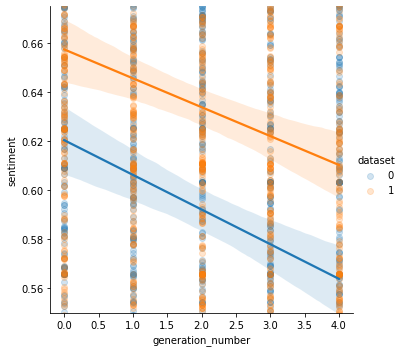

In [ ]:
g = sns.lmplot(data=newdf, x="generation_number", y="sentiment", hue="dataset", scatter_kws={'alpha':0.2})
g.set(ylim=(.55, .675))

In [ ]:
#look at goodness vs pnum for fatigue data 

goodness = []
nums = []

for pnum, group in generations1.groupby("generation_number"):
  for score in group['reflection_score']:
      if pnum <= 4:
        goodness.append(score)
        nums.append(pnum)

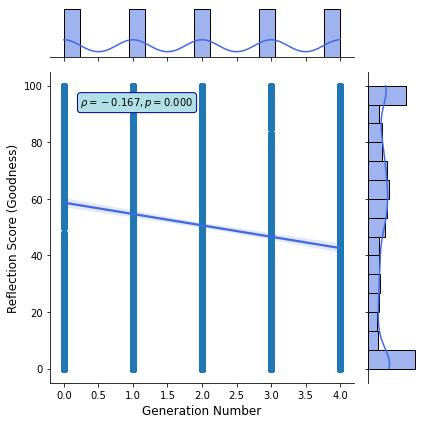

In [ ]:
g = sns.jointplot(x=nums, y=goodness, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(nums, goodness)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(nums, goodness)
g.set_axis_labels(xlabel='Generation Number', ylabel='Reflection Score (Goodness)', size=12)
plt.tight_layout()
plt.show()

In [ ]:
#look at goodness vs pnum for Eli data 

goodness = []
nums = []

for pnum, group in generations2.groupby("generation_number"):
  for score in group['reflection_score']:
      if pnum > 0:
        goodness.append(score*100)
        nums.append(pnum)

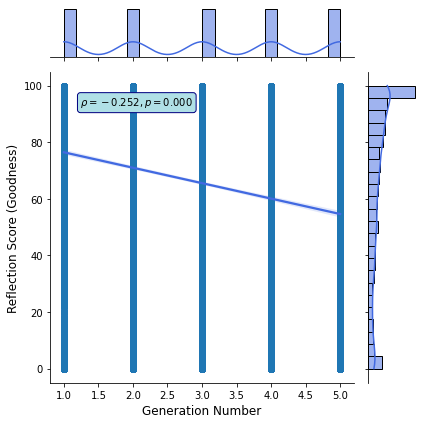

In [ ]:
g = sns.jointplot(x=nums, y=goodness, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(nums, goodness)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(nums, goodness)
g.set_axis_labels(xlabel='Generation Number', ylabel='Reflection Score (Goodness)', size=12)
plt.tight_layout()
plt.show()

In [ ]:
#combine the two 
goodness = []
nums = []
ds = []
for pnum, group in generations1.groupby("generation_number"):
  for score in group['reflection_score']:
      if pnum <= 4:
        goodness.append(score)
        nums.append(pnum + 1)
        ds.append(0)
for pnum, group in generations2.groupby("generation_number"):
  for score in group['reflection_score']:
      if pnum > 0:
        goodness.append(score*100)
        nums.append(pnum)
        ds.append(1)
df = pd.DataFrame()
df["reflection_score"] = goodness 
df["generation_number"] = nums
df["dataset"] = ds #ds = 0 is the fatigue data, 1 is eli data

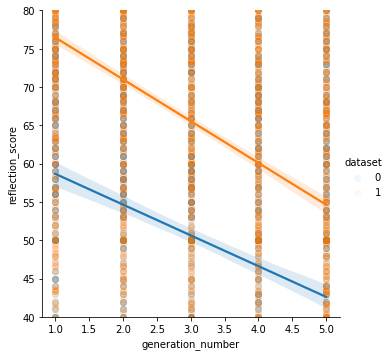

In [ ]:
g = sns.lmplot(data=df, x="generation_number", y="reflection_score", hue="dataset", scatter_kws={'alpha':0.05})
g.set(ylim=(40, 80)) # these could be dual violin plots 

In [ ]:
# I wonder about semantic exploration in this more limited dataset? Do participants explore more or less of semantic space
# the visualization that i'd like to see is one about trajectories of localizing vectors for each participant in 2d. 
# could possibly use seaborn line plots here 
generations1

,id,vignette_name,generation_number,generation_time,response,reflection_score
0,60f0ff19f34b192357d7d5d8,Brian,0,38837,review the transactions for the day and try to...,31
1,60f0ff19f34b192357d7d5d8,Brian,1,21918,look for the missing money maybe it fell under...,15
2,60f0ff19f34b192357d7d5d8,Brian,2,119718,assess if any coworkers would be likely to tak...,5
3,60f0ff19f34b192357d7d5d8,Brian,3,61550,find a trusted coworker and investigate the pr...,20
4,60f0ff19f34b192357d7d5d8,Brian,4,27189,find out if the money was missing at the start...,10
...,...,...,...,...,...,...
5665,616d9ef881036dfbfd63d2f4,Darya,1,34114,ask someone for a spare ticket,66
5666,616d9ef881036dfbfd63d2f4,Darya,2,32997,listen to the concert from outside,59
5667,616d9ef881036dfbfd63d2f4,Darya,3,29636,buy a new ticket,62
5668,616d9ef881036dfbfd63d2f4,Darya,4,35453,jump the queue,68


In [ ]:
import math 
from scipy import spatial 
def dist(r1, r2):
  r1 = np.array(r1)
  r2 = np.array(r2)
  return np.linalg.norm((r1 - r2), ord=2)
# def dist(r1, r2):
#   r1 = np.array(r1)
#   r2 = np.array(r2)
#   return spatial.distance.cosine(r1, r2)
# def dist(r1, r2):
#   r1 = np.array(r1)
#   r2 = np.array(r2)
#   return np.linalg.norm((r1 - r2), ord=1)

In [ ]:
generations = generations1

In [ ]:
# Semantic space similarity vs possibiltiy number (pairwise sim between all avg. embedding vectors)
vectordic = {}
ind_dic = {} #track each inds trajectories over pos 
#also get the corresponding sent 
sent_dic = {}
for id, group in tqdm(generations.groupby("id")):
  if id not in ind_dic: 
    ind_dic[id] = {}
    sent_dic[id] = {}
  for pnum, group2 in group.groupby("generation_number"):
    if pnum not in vectordic:
      vectordic[pnum] = []
    embeddings = []
    sentiments = []
    for generation in group2['response']:
      if not pd.isna(generation):
        embeddings.append(model.encode(generation))
        sentiments.append(predict_sentiment(generation))
    sentiments = sum(sentiments)/len(sentiments)
    embeddings = pd.DataFrame(embeddings)
    embeddings = embeddings.mean(axis=0)
    embeddings = embeddings.values.tolist()
    if len(embeddings) > 0:
      vectordic.get(pnum).append(embeddings)
      ind_dic[id][pnum] = embeddings
      sent_dic[id][pnum] = sentiments

100%|██████████| 105/105 [01:51<00:00,  1.06s/it]


In [ ]:
#semantic space dissimilarity vs generation nums
similarity = []
nums = []
avg_dic = {}
for num in vectordic:
  avg_dic[num] = []
  for i in range(len(vectordic.get(num))):
    for j in range(i+1, len(vectordic.get(num))):
      nums.append(num)
      s = dist(vectordic.get(num)[i], vectordic.get(num)[j])
      similarity.append(s)
      avg_dic[num].append(s)


In [ ]:
# remove invalid data - why would the distance between two distinct localizing vectors be 0? 
x = nums
y = similarity
i = 0 
avg_dic = {}
while i < len(x):
  if y[i] == 0:
    y.pop(i)
    x.pop(i)
    i -= 1
  else:
    if x[i] not in avg_dic:
      avg_dic[x[i]] = []
    avg_dic[x[i]].append(y[i])
  i += 1
x_avg = []
y_avg = []
for num in avg_dic:
  avg_dic[num] = sum(avg_dic[num])/len(avg_dic[num])
  x_avg.append(num)
  y_avg.append(avg_dic[num])

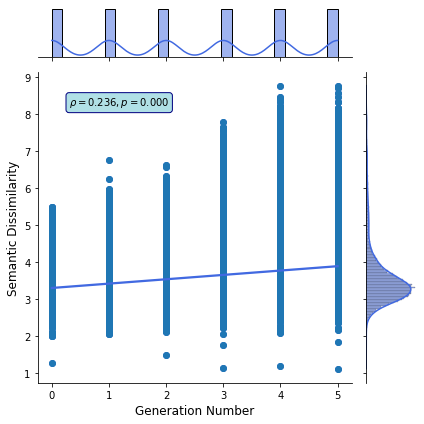

In [ ]:
#plotting to find stats 
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Number', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

id_order = []
gen_order = []
sent_order = []
ndf = pd.DataFrame()
thresh = 90

In [ ]:
i = 0 
for id in ind_dic:
  for pnum in ind_dic[id]:
    #apped the localizing vector for the ith possibility; we can also collect the average sentiment for this. 
    ndf = ndf.append((pd.DataFrame(ind_dic[id][pnum]).T), ignore_index=True)
    id_order.append(id)
    gen_order.append(pnum)
    sent_order.append(sent_dic[id][pnum])
  i +=1 
  if i >= thresh: 
    break


In [ ]:
ndf = StandardScaler().fit_transform(ndf)
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(ndf)
ndf = pd.DataFrame(data = principalComponents, columns = ['pc1'])

In [ ]:
for i in range(len(sent_order)):
  sent_order[i] = round(sent_order[i], 1)

In [ ]:
ndf["id"] = id_order
ndf["number"] = gen_order
ndf["sentiment"] = sent_order

In [ ]:
ndf

,pc1,id,number,sentiment
0,-1.951239,55b2d3f2fdf99b525bc839aa,0,0.5
1,-4.098039,55b2d3f2fdf99b525bc839aa,1,0.8
2,-1.597589,55b2d3f2fdf99b525bc839aa,2,0.5
3,-2.476756,55b2d3f2fdf99b525bc839aa,3,0.6
4,-4.336053,55b2d3f2fdf99b525bc839aa,4,0.7
...,...,...,...,...
535,-4.131039,614685212685b4cd94233a32,1,0.8
536,-0.889152,614685212685b4cd94233a32,2,0.7
537,-3.214250,614685212685b4cd94233a32,3,0.7
538,0.855061,614685212685b4cd94233a32,4,0.6


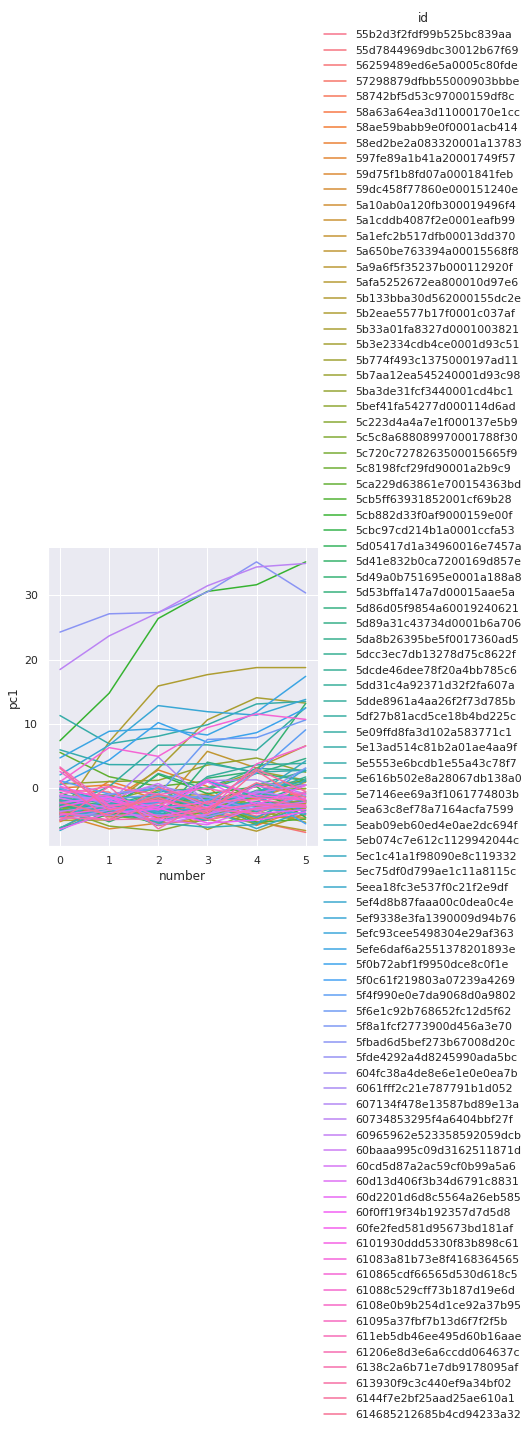

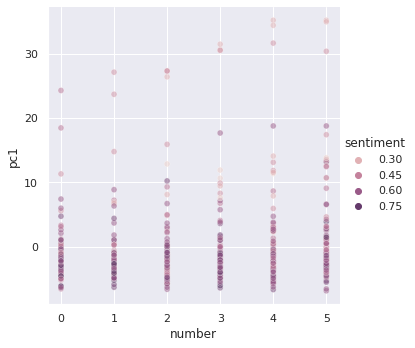

In [ ]:
#can use hue and style to further stratify
sns.set(rc={'figure.figsize':(3*11.7,3*8.27)})
# color = sns.color_palette("flare", as_cmap=True)
# g = sns.lineplot(data=ndf, x="number", y="pc1", hue="id")

g = sns.relplot(data=ndf, x="number", y="pc1", hue="id", kind="line", legend="brief")
g = sns.relplot(data=ndf, x="number", y="pc1", hue="sentiment", kind="scatter", alpha=.5)

/usr/local/lib/python3.7/dist-packages/seaborn/relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try lineplot
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


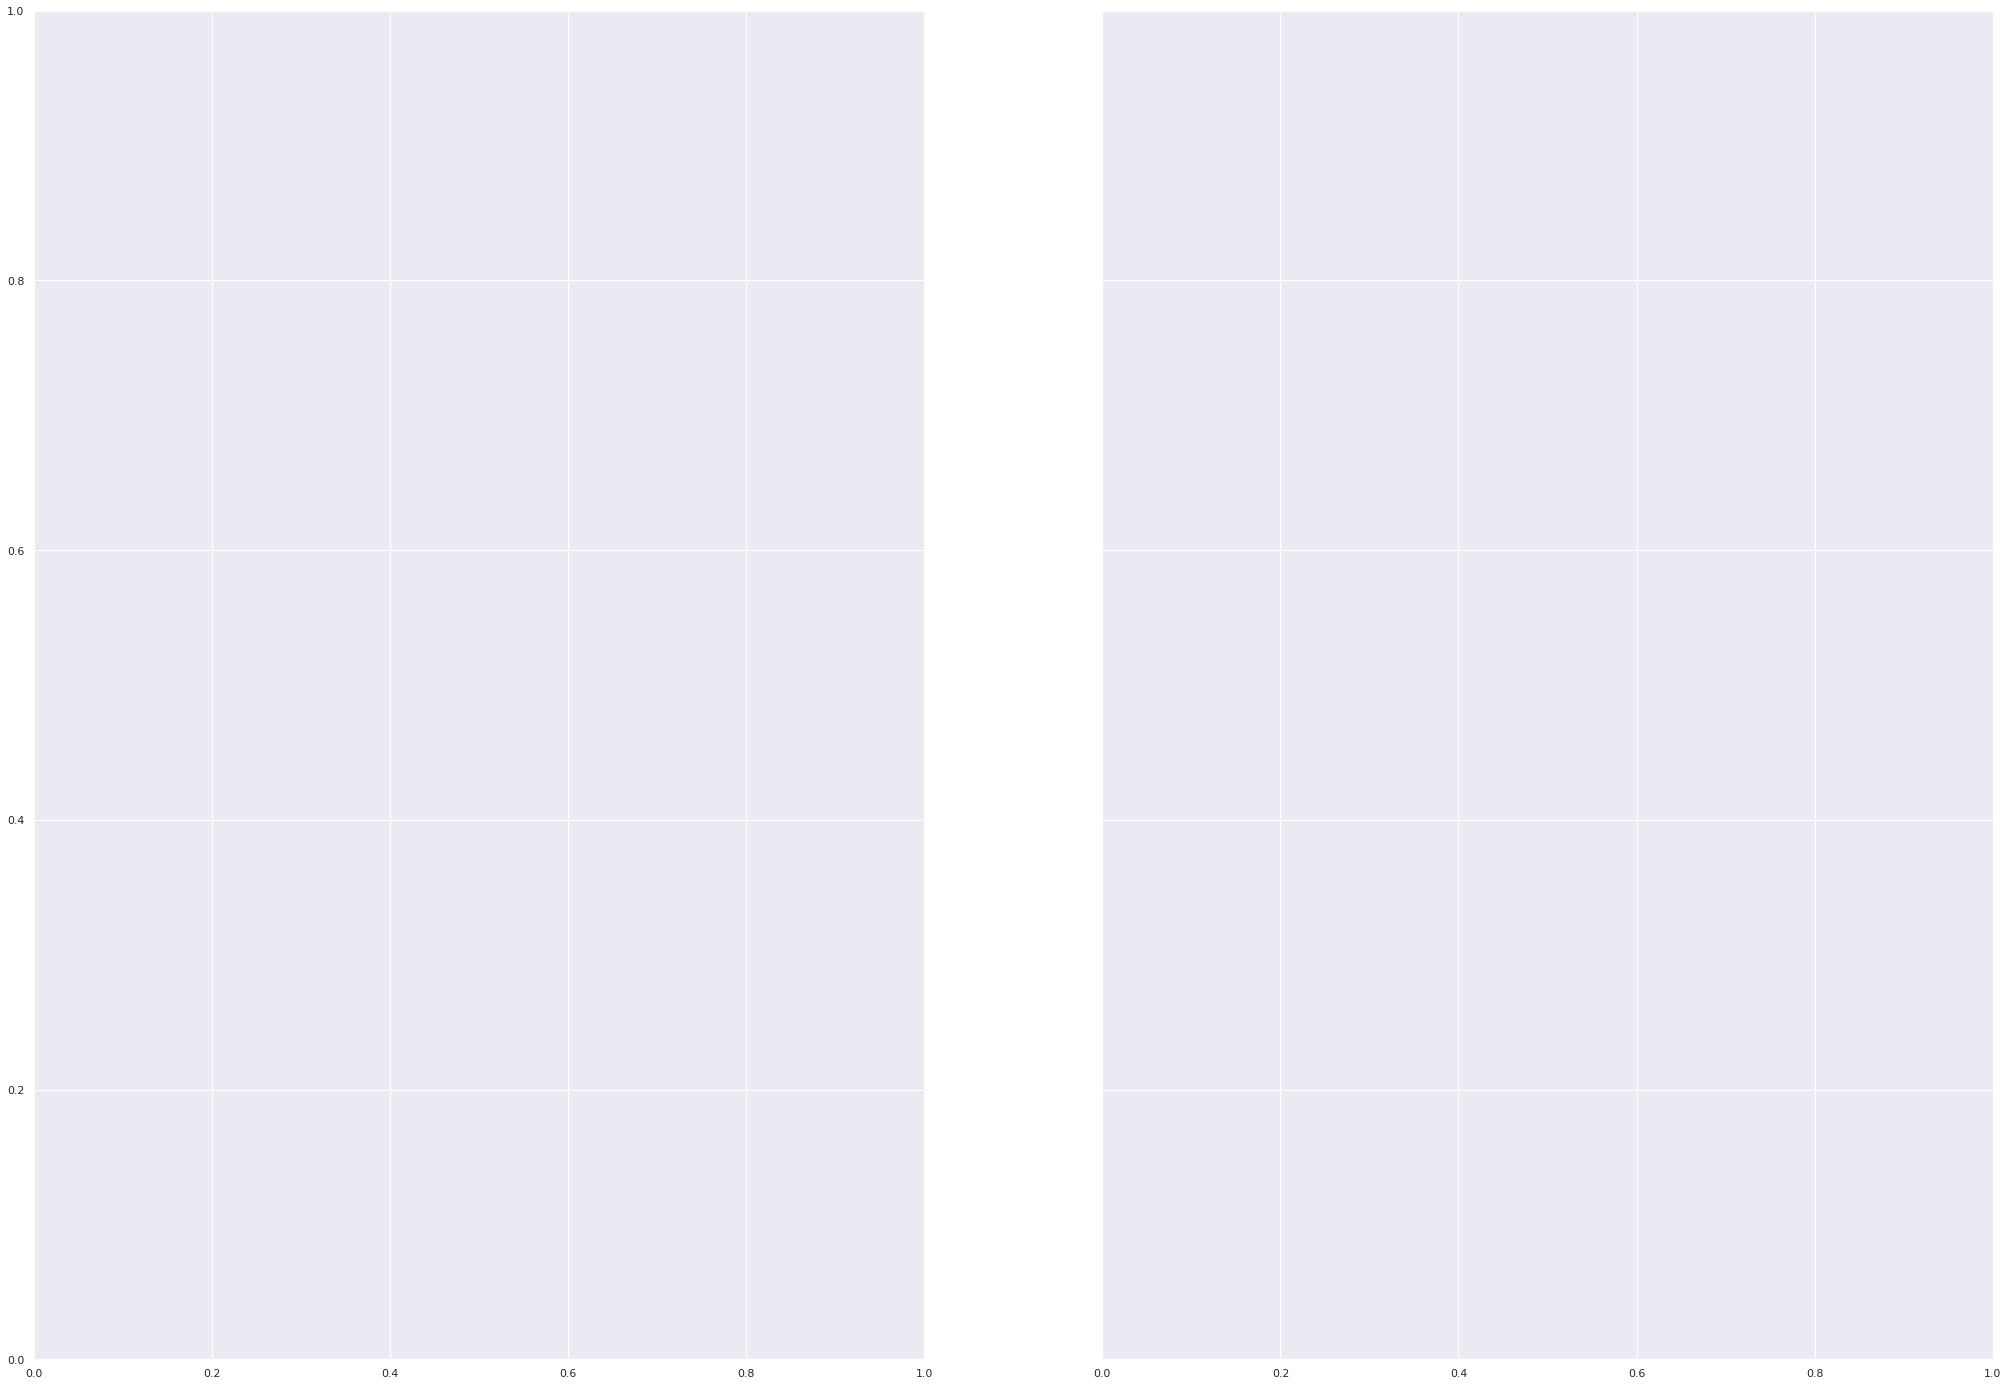

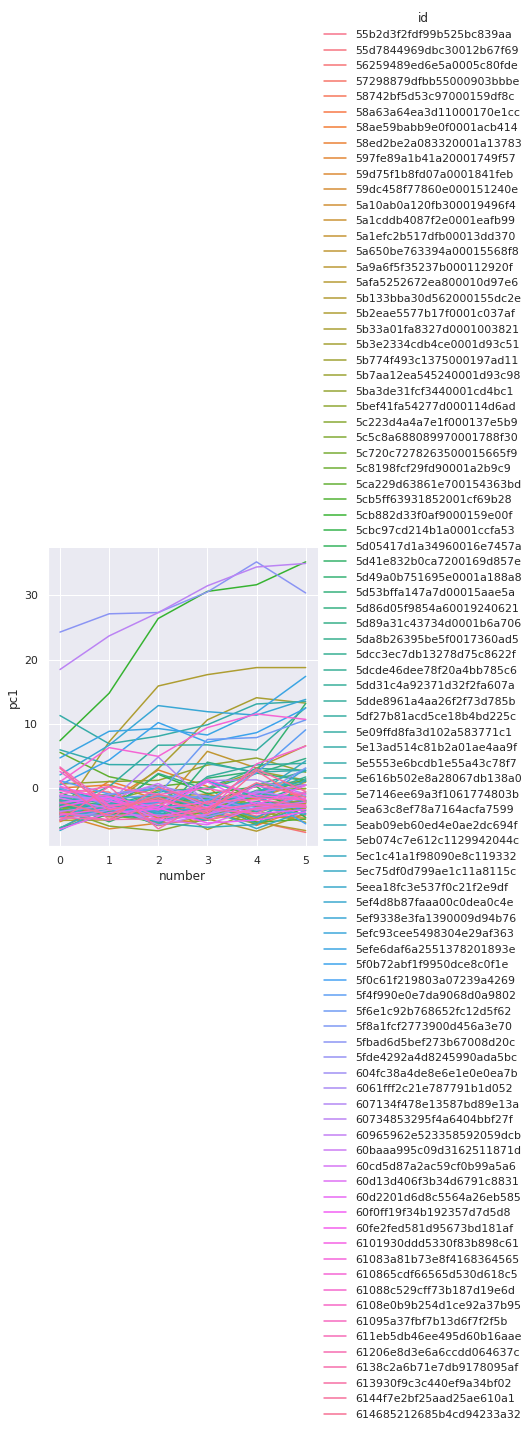

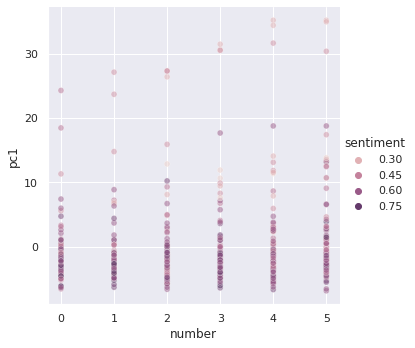

In [ ]:

# call regplot on each axes
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.relplot(data=ndf, x="number", y="pc1", hue="id", kind="line", legend="brief", ax = ax1)
sns.relplot(data=ndf, x="number", y="pc1", hue="sentiment", kind="scatter", alpha=.5, ax=ax2)


#Semantic Exploration Stuff

In [ ]:
# Real semantic exploration 
#exploration and answers tally average
exploration = {}
answers = {}
#exp and nums tally the individual explorations
exp = []
nums = []
id_exp = {}
for id, group in tqdm(generations.groupby("id")):
  if id not in id_exp: 
    id_exp[id] = {}
  for pnum, group2 in group.groupby("generation_number"):
    if pnum not in exploration: 
      exploration[pnum] = []
      # answers[pnum] = 0
    embeddings = []
    for response, group3 in group2.groupby("response"):
      response = group3['response'].to_list()[0]
      if not pd.isna(response):
        embeddings.append(model.encode(response).tolist())
    # answers[pnum] += len(embeddings)
    if len(embeddings) > 0:
      e = 0
      for i in range(len(embeddings)):
        for j in range(i+1, len(embeddings)):
          e += dist(embeddings[i], embeddings[j])
      exploration[pnum].append(e/len(embeddings))
      exp.append(e/len(embeddings))
      nums.append(pnum)

x_avg = []
y_avg = []
for num in exploration:
  x_avg.append(num)
  y_avg.append(sum(exploration[num])/len(exploration[num]))

In [ ]:
#plotting for stats
g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

In [ ]:
ind_exp = {}
for id, group in tqdm(generations.groupby("id")):
  if id not in ind_exp:
    ind_exp[id] = {}
  for vign, group2 in group.groupby("vignette_name"):
    if vign not in ind_exp[id]:
      ind_exp[id][vign] = [0]*6
    for pnum, group3 in group2.groupby("generation_number"):
      for response, group4 in group3.groupby("response"):
        if not pd.isna(response):
          ind_exp[id][vign][pnum] = model.encode(response).tolist()

In [ ]:
print(ind_exp)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#we need to fix a particular participant
# target = "55b2d3f2fdf99b525bc839aa"
thresh= 20
vign_order = []
gen_order = []
id_order = []
ndf = pd.DataFrame()

In [ ]:
j = 0
for id in ind_exp: 
  for vign in ind_exp[id]:
    for i in range(len(ind_exp[id][vign])):
      vign_order.append(vign)
      gen_order.append(i)
      id_order.append(id)
      ndf = ndf.append(pd.DataFrame(ind_exp[id][vign][i]).T, ignore_index = True)
  j += 1
  if j >= thresh: 
    break 
    

In [ ]:
ndf

In [ ]:
ndf = StandardScaler().fit_transform(ndf)
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(ndf)
ndf = pd.DataFrame(data = principalComponents, columns = ['pc1'])

In [ ]:
ndf["vign"] = vign_order
ndf["number"] = gen_order
ndf["id"] = id_order

In [ ]:
ndf

In [ ]:
#can use hue and style to further stratify
# sns.set(rc={'figure.figsize':(3*11.7,3*8.27)})
g = sns.relplot(data=ndf, x="number", y="pc1", hue="vign", col="id", kind="line", col_wrap=5)


In [ ]:
#is there a way to add sentiment to the points in these plots 